# Implementation
``numpy`` is used for numerical operations. 

``matplotlib`` is used to graph results. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

Constants for lattice basis and nearest neighbor displacements.

In [2]:
# Hexagonal
H_BASIS = np.array([[1, 0], [0.5, np.sqrt(3)/2]])
H_NN = np.array([
    [1, 0],
    [0, 1],
    [-1, 0],
    [0, -1],
    [1, -1],
    [-1, 1]
])
# Square
S_BASIS = np.array([[1, 0], [0, 1]])
S_NN = np.array([
    [1, 0],
    [0, 1],
    [-1, 0],
    [0, -1],
])


In [3]:
# finds nearest neighbors to position p with PBC
def find_PBC_NN(p, l_shape, nn): return np.mod(np.tile(p, (nn.shape[0], 1)) + nn, l_shape)


def find_PBC_H_NN(p, l_shape): return find_PBC_NN(p, l_shape, H_NN)


def find_PBC_S_NN(p, l_shape): return find_PBC_NN(p, l_shape, S_NN)

The grain lattice is populated by selecting ``n_grains`` random sites as grain origins, and then generating a voronoi diagram based on Euclidean distance to grain origins.

In [5]:
# Generates voronoi lattice with crystal grains.
def generate_voronoi(lattice, n_grains, basis):
    # TODO: implement basis

    # determines unique grain origins
    origins = np.random.choice(
        np.arange(lattice.size), n_grains, replace=False)
    origins = np.vstack((
        np.mod(origins, lattice.shape[0]),
        np.floor_divide(origins, lattice.shape[1])
    )).T

    # gets 2x(lattice.size) numpy arrays of all positions in the lattice
    all_lattice_pos = np.vstack(np.meshgrid(
        np.arange(lattice.shape[0]), np.arange(lattice.shape[1]))).reshape(2, -1).T
    # converst to cartesian coordinates
    all_cart_pos = np.matmul(basis, all_lattice_pos.T).T
    cart_origins = np.matmul(basis, origins.T).T
    # in lattice basis: relative distance of each lattice point to grain origins, each element corresponds to one origin point
    rel = np.repeat(all_cart_pos, n_grains, axis=0).reshape(
        lattice.size, n_grains, 2) - np.tile(cart_origins, (lattice.size, 1, 1))
    # gets euclidean distance for each lattice point to grain origin
    dist = np.sum(np.square(rel), axis=2)
    # TODO: make this vectorized
    populated_lattice = np.array([np.random.choice(np.where(dist[i] == dist[i][np.argmin(
        dist[i])])[0]) for i in range(lattice.size)]).reshape(lattice.shape).T
    counts = np.bincount(populated_lattice.flatten())
    return populated_lattice, origins, counts


In [6]:
def find_boundaries(lattice, nn_f):
    """
    Finds boundary lattice positions, with neighbors having different lattice values.

    Arguments:
     - lattice: lattice to return boundaries
     - nn_f: function to find nearest neighbor indices given position, returns 
     ndarray with row neighbor positions
    """
    # TODO: optimize by only searching nn to previous boundaries
    boundaries = set()
    for i in range(lattice.shape[0]):
        for j in range(lattice.shape[1]):
            # finds unique nearest neighbor lattice sites within lattice boundaries
            nn = nn_f(np.array([i, j]), lattice.shape).T
            if np.any(lattice[nn[0], nn[1]] != lattice[i, j]):
                boundaries.add((i, j))

    return boundaries


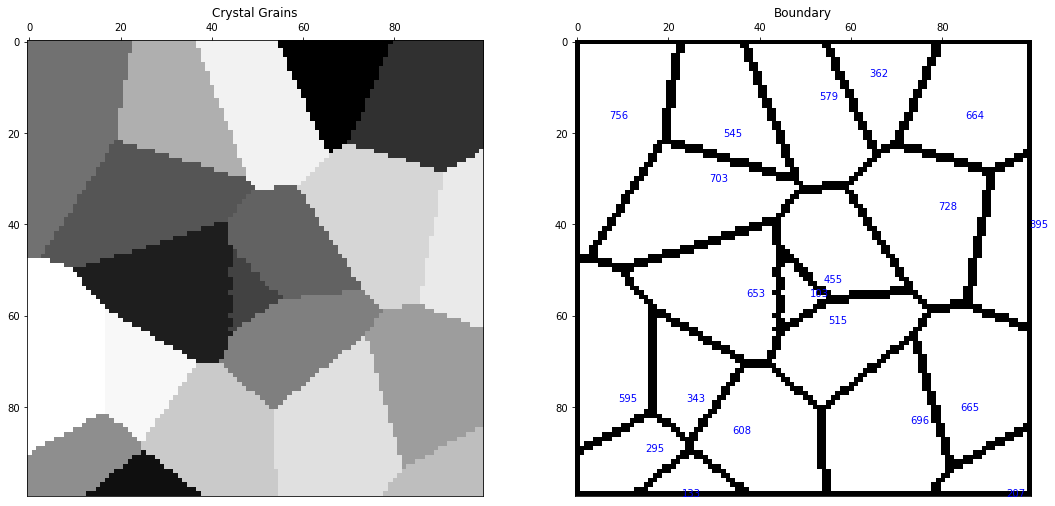

In [7]:
# An example visualization of grain lattice and boundaries
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# simple square lattice with (i-hat, j-hat) lattice basis
s_lattice = np.empty(shape=(100, 100))
s_lattice, origins, counts = generate_voronoi(
    s_lattice, 20, np.array([[1, 0], [0, 1]]))
s_boundaries = np.array([*find_boundaries(s_lattice, find_PBC_S_NN)])

boundary_marked = np.zeros(shape=s_lattice.shape)
boundary_marked[s_boundaries.T[0], s_boundaries.T[1]] = 1

fig, axs = plt.subplots(1, 2)
fig.set_size_inches((18, 18))
axs[0].imshow(s_lattice, cmap="Greys")
axs[0].xaxis.tick_top()
axs[0].set_title("Crystal Grains")
axs[1].imshow(boundary_marked, cmap="binary")
axs[1].xaxis.tick_top()
axs[1].set_title("Boundary")
for i, o in enumerate(origins):
    axs[1].text(o[1], o[0], str(counts[i]),
                horizontalalignment='left',
                verticalalignment='center',
                color='blue')

In [8]:
def boundary_pf(boundaries):
    """
    This proposal function for the Metropolis algorithm selects a random boundary
    point to be flipped. Non-boundary points do not flip with a nearest neighbor
    approximation.
    """
    return np.array([*boundaries])[np.random.randint(0, len(boundaries))]


In [9]:
def metropolis_qstate(shape, n_grains, nn_f, basis, pf, kj_prod, T, n_steps, burn_steps):
    """
    Metropolis algorithm for the Q-states model.

    Arguments:
     - lattice_i: The initial crystal grain lattice
     - n_grains:  number of grains
     - size: size of the lattice (along one axis)
     - nn_f: returns nearest neighbors for given lattice position
     - pf: function to propose new lattice flip positions
     - kj_prod: Product between J spin interation value and Boltzmann's constant
     - T: system temperature
     - n_steps: total MC steps
     - burn_steps: steps burned initially for system thermal relaxation
    """
    lattice = np.empty(shape=shape)
    lattice, origins, counts = generate_voronoi(lattice, n_grains, basis)
    boundaries = find_boundaries(lattice, nn_f)
    accepted = [lattice.copy()]
    counts_history = [counts.copy()]
    total_steps = n_steps

    for s in range(n_steps):
        if len(boundaries) == 0:
            print(f"No boundaries left at step {s}")
            total_steps = s + 1
            break
        pos = pf(boundaries)  # proposed position
        o_init = lattice[pos[0], pos[1]]  # orientation of selected position
        nn = nn_f(pos, shape).T  # 2 x n array of nearest neighbor positions
        o_nn = lattice[nn[0], nn[1]]  # orientation of neighbors
        
        possible_o = np.arange(n_grains)
        # choose new distinct orientation to switch to
        o_final = np.random.choice(possible_o[possible_o != o_init])  # any random orientation can be chosen
        H_i = np.sum(o_nn == o_init)  # intial Hamiltonian factor
        H_f = np.sum(o_nn == o_final)  # final Hamiltonian factor
        # natural log of acceptance ratio
        ln_ar = kj_prod / T * (H_f - H_i)
        if ln_ar >= 0 or ln_ar > np.log(np.random.random()):
            lattice[pos[0], pos[1]] = o_final
            counts[o_init] -= 1
            counts[o_final] += 1

            # update boundary
            if not np.any(lattice[nn[0], nn[1]] != lattice[pos[0], pos[1]]):
                boundaries.remove(tuple(pos))

            for neighbor in nn.T:
                neighbor_nn = nn_f(neighbor, shape).T
                if np.any(lattice[neighbor_nn[0], neighbor_nn[1]] != lattice[neighbor[0], neighbor[1]]):
                    boundaries.add(tuple(neighbor))
                else:
                    boundaries.remove(tuple(neighbor))

            if s > burn_steps - 1:
                accepted.append(lattice.copy())
                counts_history.append(counts.copy())

    return np.array(accepted), origins, np.array(counts_history), total_steps


In [72]:
simulation_results, origins, counts_history, total_steps = metropolis_qstate((20, 20), 5, find_PBC_S_NN, S_BASIS, boundary_pf, 1, 1, 10000, 1000)

In [73]:
diameters = np.sqrt(4 * counts_history / np.pi)  # creates diameters based on number of grain for each orientationbb

<IPython.core.display.Javascript object>


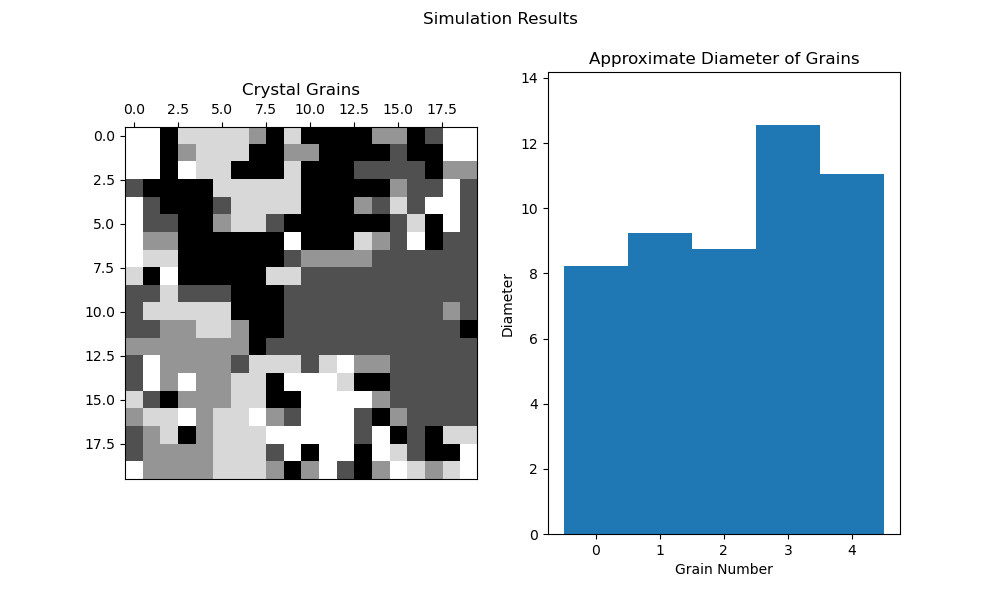

In [75]:
%matplotlib notebook
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("Simulation Results")
im = axs[0].imshow(simulation_results[0], cmap="Greys")
axs[0].xaxis.tick_top()
axs[0].set_title("Crystal Grains")
axs[0].set_aspect("equal")
bars = axs[1].bar(np.arange(origins.shape[0]), diameters[0], width=1)
axs[1].set_ylim(0, np.max(diameters))
axs[1].set_title("Approximate Diameter of Grains")
axs[1].set_xlabel("Grain Number")
axs[1].set_ylabel("Diameter")

speed_up_factor = 10
def animate(frame):
    step = frame * speed_up_factor
    im.set_array(simulation_results[step])
    for i, bar in enumerate(bars):
        bar.set_height(diameters[step][i])
    return im


anim = FuncAnimation(fig, animate, frames=int(total_steps/speed_up_factor), interval=15000/total_steps/speed_up_factor, blit=True)
plt.show()